# Applications of Quantum Machine Learning in Marketing
Bachelorthesis by Maximilian Priessnitz<br>
June 2024 - Vienna, Austria<br>
Content: This notebook shows the practical part of the bachelor thesis, which optimizes the classic support vector classifier (and its kernel variations) and tests it against the optimized quantum support vector classifier.

### Extra Installation

In [58]:
#%pip install qiskit qiskit-machine-learning

In [59]:
#%pip install pydantic==1.7.2

## Data Preparation
The data preparation aims to find the best features (based on the time quantum simulation restrictions) and clean the data.<br>
For this thesis the "Telco" dataset gives the best practical showcase.<br>
I use 200 rows because of time issues during the quantum simulation.

In [60]:
import pandas as pd

file_path = 'telco.csv'

org_df = pd.read_csv(file_path)

df = org_df.sample(n=300, random_state=123)
# df = org_df

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
941,0811-GSDTP,Female,0,No,Yes,13,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,30.15,382.2,No
1404,1970-KKFWL,Female,0,No,No,35,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.30,797.1,No
5515,2892-GESUL,Female,0,Yes,Yes,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,309.25,No


In [61]:
csv_path = 'sampled_df.csv'
df.to_csv(csv_path, index=False)

In [62]:
first_row = df.iloc[0]

for column in df.columns:
    dtype = df[column].dtype
    example_value = first_row[column]
    print(f"{column} ({dtype}): {example_value}")

customerID (object): 0811-GSDTP
gender (object): Female
SeniorCitizen (int64): 0
Partner (object): No
Dependents (object): Yes
tenure (int64): 13
PhoneService (object): No
MultipleLines (object): No phone service
InternetService (object): DSL
OnlineSecurity (object): No
OnlineBackup (object): Yes
DeviceProtection (object): No
TechSupport (object): No
StreamingTV (object): No
StreamingMovies (object): No
Contract (object): Month-to-month
PaperlessBilling (object): No
PaymentMethod (object): Electronic check
MonthlyCharges (float64): 30.15
TotalCharges (object): 382.2
Churn (object): No


In [63]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
941,0811-GSDTP,Female,0,No,Yes,13,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,30.15,382.2,No
1404,1970-KKFWL,Female,0,No,No,35,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.30,797.1,No
5515,2892-GESUL,Female,0,Yes,Yes,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,309.25,No
3684,2842-BCQGE,Male,0,No,No,43,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.35,3161.4,No
7017,4807-IZYOZ,Female,0,No,No,51,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.65,1020.75,No


In [64]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Make a copy of the original DataFrame
df_processed = df.copy()

# Drop CustomerID column
df_processed.drop(columns=['customerID'], inplace=True)

# Change Churn behaviour
df_processed["Churn"] = df_processed["Churn"].replace({'Yes': 1, 'No': 0}).infer_objects(copy=False)

# Convert SeniorCitizen column from 0/1 to 'No'/'Yes'
df_processed['SeniorCitizen'] = df_processed['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

df_processed.head(5)

/var/folders/64/zkcqc27x1p3cgq_28fymy7700000gn/T/ipykernel_60515/1460241011.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed["Churn"] = df_processed["Churn"].replace({'Yes': 1, 'No': 0}).infer_objects(copy=False)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
941,Female,No,No,Yes,13,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.15,382.2,0
1404,Female,No,No,No,35,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.30,797.1,0
5515,Female,No,Yes,Yes,18,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,309.25,0
3684,Male,No,No,No,43,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.35,3161.4,0
7017,Female,No,No,No,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.65,1020.75,0


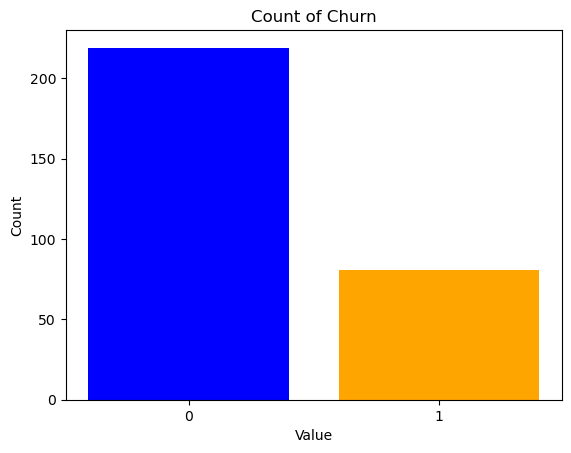

In [65]:
# Split up the different handlings

df_processed_num = df_processed[["tenure", "MonthlyCharges", "TotalCharges"]]
# Change to numeric (see object types before)
df_processed_num = df_processed_num.apply(pd.to_numeric, errors='coerce')

df_processed_cat = df_processed[["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "Contract", "PaperlessBilling", "PaymentMethod"]]
df_processed_churn = df_processed["Churn"]

# Count the occurrences of 0 and 1 in the 'Churn' column
count_0 = df_processed_churn.value_counts().get(0, 0)
count_1 = df_processed_churn.value_counts().get(1, 0)

# Create a Churn Count Chart
import matplotlib.pyplot as plt

labels = ['0', '1']
counts = [count_0, count_1]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Count of Churn')
plt.show()

In [66]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the data
df_scaled = scaler.fit_transform(df_processed_num)
df_scaled = pd.DataFrame(df_scaled, columns=df_processed_num.columns)
df_scaled.head(5)

,tenure,MonthlyCharges,TotalCharges
0,-0.818807,-1.152257,-0.827187
1,0.070908,-1.381768,-0.649395
2,-0.616599,-1.514114,-0.858447
3,0.394440,0.362181,0.363750
4,0.717973,-1.470557,-0.553557


In [67]:
# Split cat variables
enc = OneHotEncoder(sparse_output=False)
ohe = enc.fit_transform(df_processed_cat)
ohe_df = pd.DataFrame(ohe, columns=enc.get_feature_names_out(df_processed_cat.columns.tolist()))

In [68]:
# Concat the telco for feature selection and model training
telco = pd.concat([df_scaled, ohe_df], axis=1)
telco = pd.concat([telco, df_processed_churn.set_axis(telco.index)], axis=1)
telco = telco.fillna(0)
telco.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-0.818807,-1.152257,-0.827187,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,0.070908,-1.381768,-0.649395,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
2,-0.616599,-1.514114,-0.858447,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3,0.394440,0.362181,0.363750,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,0.717973,-1.470557,-0.553557,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0


In [69]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import numpy as np

X = telco.drop('Churn', axis=1)
y = telco['Churn']

svc = SVC(kernel="linear")

# Define function for RFE within cross-validation
def rfe_selection(X_train, y_train, n_features):
    rfe = RFE(estimator=svc, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    return rfe

# RFE on the whole dataset to find selected features
rfe_model = rfe_selection(X, y, 5)
selected_features = X.columns[rfe_model.support_]

print("Selected features:", selected_features)

# Selecting only the important features for the dataset
X_selected = X[selected_features]

# Splitting the data into training and testing sets with 80% training data and 20% testing data
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_selected, y, test_size=0.20, random_state=42)

# Splitting the data into training and testing sets with 70% training data and 30% testing data
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_selected, y, test_size=0.30, random_state=42)

Selected features: Index(['tenure', 'Dependents_Yes', 'InternetService_Fiber optic',
       'PaperlessBilling_Yes', 'PaymentMethod_Mailed check'],
      dtype='object')


In [70]:
# X_train_80.head(5)
# X_train_80.dtypes
X_train_80.count()

tenure                         240
Dependents_Yes                 240
InternetService_Fiber optic    240
PaperlessBilling_Yes           240
PaymentMethod_Mailed check     240
dtype: int64

In [71]:
# X_test_20.head(5)
# X_test_20.dtypes
X_test_20.count()

tenure                         60
Dependents_Yes                 60
InternetService_Fiber optic    60
PaperlessBilling_Yes           60
PaymentMethod_Mailed check     60
dtype: int64

In [72]:
# y_train_80.head(5)
y_train_80.count()

240

In [73]:
# y_test_20.head(5)
y_test_20.count()

60

## Finding the perfect Parameters
After the scaling and selecting the reduced amount of features, I continue the analysis with a grid search for hyperparameter tuning with 2 different splits.<br>
At first a 80:20 split for the traning and test data, and in the second round a 70:30 split.

### SVC

#### Folds

In [74]:
folds = 2

In [75]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_80), y=y_train_80)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

svc = SVC(probability=True, class_weight=class_weights_dict)

# Set up the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]
}

# Define scorers
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)
precision_scorer = make_scorer(precision_score, zero_division=0)

scoring = {
    'accuracy': 'accuracy',
    'precision': precision_scorer,
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': roc_auc_scorer
}

##### 80 - 20

In [76]:
# Initialize the GridSearchCV object with stratified k-fold
grid_search_8020 = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=folds),
    verbose=10,
    n_jobs=-1
)

# Fit the grid search
start_time = time.time()
grid_search_8020.fit(X_train_80, y_train_80)
end_time = time.time()
training_time_8020 = end_time - start_time

# Best parameters and best ROC-AUC score
print("Best parameters found:", grid_search_8020.best_params_)
print("Best accuracy score with cross-validation:", grid_search_8020.best_score_)

# Evaluate all metrics for the best model
best_model = grid_search_8020.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model.predict(X_test_20)
end_time = time.time()
time_taken_8020_pred = end_time - start_time

print(f"Time taken for training (80-20 split): {training_time_8020:.4f} seconds")
print(f"Time taken for prediction (80-20 split): {time_taken_8020_pred:.4f} seconds")
print("Accuracy:", accuracy_score(y_test_20, y_pred))
print("Precision:", precision_score(y_test_20, y_pred, zero_division=0))
print("Recall:", recall_score(y_test_20, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test_20, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test_20, best_model.predict_proba(X_test_20)[:, 1]))

Fitting 2 folds for each of 126 candidates, totalling 252 fits
[CV 2/2; 4/126] START C=0.001, gamma=auto, kernel=linear........................
[CV 2/2; 4/126] END C=0.001, gamma=auto, kernel=linear; accuracy: (test=0.267) f1: (test=0.421) precision: (test=0.267) recall: (test=1.000) roc_auc: (test=0.815) total time=   0.0s
[CV 1/2; 6/126] START C=0.001, gamma=auto, kernel=poly..........................
[CV 1/2; 6/126] END C=0.001, gamma=auto, kernel=poly; accuracy: (test=0.267) f1: (test=0.421) precision: (test=0.267) recall: (test=1.000) roc_auc: (test=0.789) total time=   0.0s
[CV 1/2; 8/126] START C=0.001, gamma=0.01, kernel=rbf...........................
[CV 1/2; 8/126] END C=0.001, gamma=0.01, kernel=rbf; accuracy: (test=0.267) f1: (test=0.421) precision: (test=0.267) recall: (test=1.000) roc_auc: (test=0.797) total time=   0.0s
[CV 2/2; 11/126] START C=0.001, gamma=0.1, kernel=rbf...........................
[CV 2/2; 11/126] END C=0.001, gamma=0.1, kernel=rbf; accuracy: (test=0.2

##### 70 - 30

In [77]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_70), y=y_train_70)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

svc = SVC(probability=True, class_weight=class_weights_dict)

# Initialize the GridSearchCV object with stratified k-fold
grid_search_7030 = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=folds),
    verbose=10,
    n_jobs=-1
)


# Fit the grid search
start_time = time.time()
grid_search_7030.fit(X_train_70, y_train_70)
end_time = time.time()
training_time_7030 = end_time - start_time

# Best parameters and best ROC-AUC score
print("Best parameters found:", grid_search_7030.best_params_)
print("Best accuracy score with cross-validation:", grid_search_7030.best_score_)

# Evaluate all metrics for the best model
best_model = grid_search_7030.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model.predict(X_test_30)
end_time = time.time()
time_taken_7030_pred = end_time - start_time

print(f"Time taken for training (70-30 split): {training_time_7030:.4f} seconds")
print(f"Time taken for prediction (70-30 split): {time_taken_7030_pred:.4f} seconds")
print("Accuracy:", accuracy_score(y_test_30, y_pred))
print("Precision:", precision_score(y_test_30, y_pred, zero_division=0))
print("Recall:", recall_score(y_test_30, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test_30, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test_30, best_model.predict_proba(X_test_30)[:, 1]))

Fitting 2 folds for each of 126 candidates, totalling 252 fits
[CV 1/2; 2/126] START C=0.001, gamma=scale, kernel=rbf..........................
[CV 1/2; 2/126] END C=0.001, gamma=scale, kernel=rbf; accuracy: (test=0.267) f1: (test=0.421) precision: (test=0.267) recall: (test=1.000) roc_auc: (test=0.806) total time=   0.0s
[CV 2/2; 12/126] START C=0.001, gamma=0.1, kernel=poly..........................
[CV 2/2; 12/126] END C=0.001, gamma=0.1, kernel=poly; accuracy: (test=0.267) f1: (test=0.421) precision: (test=0.267) recall: (test=1.000) roc_auc: (test=0.803) total time=   0.0s
[CV 2/2; 15/126] START C=0.001, gamma=1, kernel=poly............................
[CV 2/2; 15/126] END C=0.001, gamma=1, kernel=poly; accuracy: (test=0.517) f1: (test=0.500) precision: (test=0.345) recall: (test=0.906) roc_auc: (test=0.803) total time=   0.0s
[CV 2/2; 19/126] START C=0.001, gamma=100, kernel=linear........................
[CV 2/2; 19/126] END C=0.001, gamma=100, kernel=linear; accuracy: (test=0.2

### QSVC

#### Feature Map

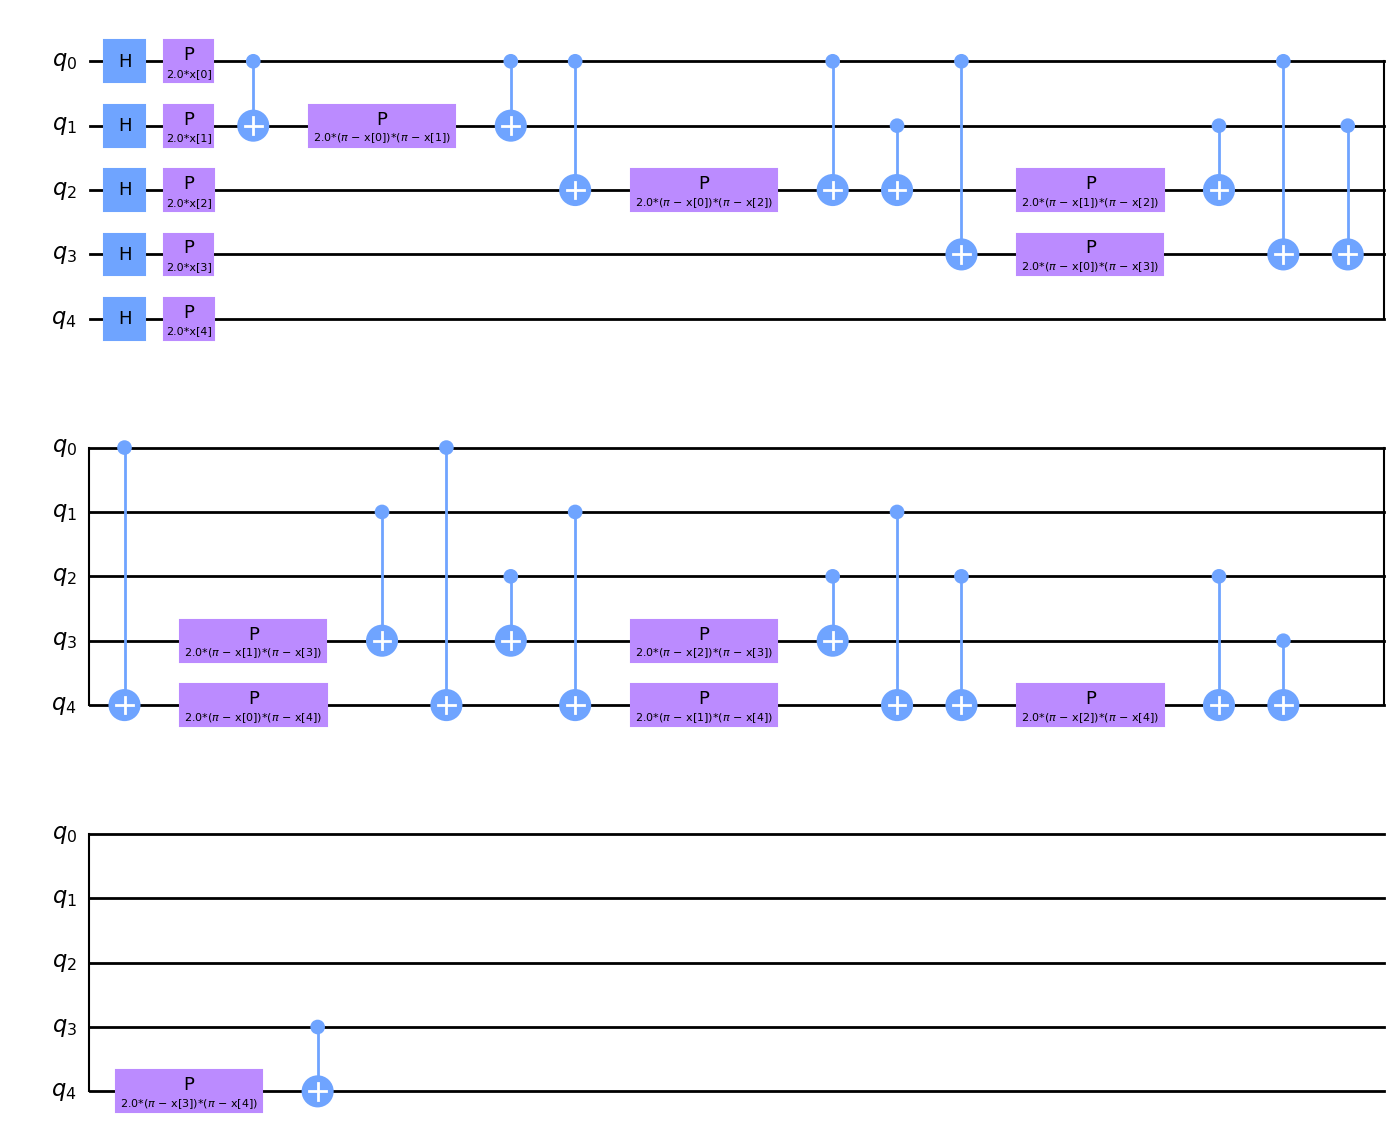

In [78]:
from qiskit.circuit.library import ZZFeatureMap

num_features = telco[selected_features].shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

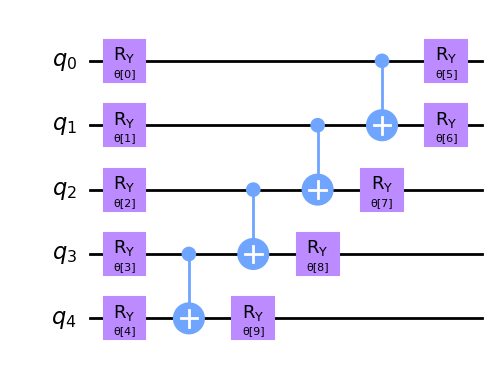

In [79]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

#### Folds

In [80]:
import numpy as np
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
import time
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin

class QSVCWithProgress(QSVC):
    def fit(self, X, y, **fit_params):
        with tqdm(total=len(self.param_grid['C']) * len(self.param_grid['gamma']) * self.cv) as pbar:
            for params in tqdm(self.param_grid):
                self.set_params(**params)
                super().fit(X, y, **fit_params)
                pbar.update(1)
        return self

# Quantum kernel with ZZFeatureMap and FidelityQuantumKernel
feature_map = ZZFeatureMap(feature_dimension=X_train_80.shape[1], reps=1)
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_80), y=y_train_80)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Quantum SVM with the quantum kernel
qsvc = QSVC(quantum_kernel=quantum_kernel, class_weight=class_weights_dict)

# Set up the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]
}

# Define scorers
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)
precision_scorer = make_scorer(precision_score, zero_division=0)

scoring = {
    'accuracy': 'accuracy',
    'precision': precision_scorer,
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': roc_auc_scorer
}

##### 80-20

In [81]:
# Initialize the GridSearchCV object with stratified k-fold and progress bar
grid_search_8020 = GridSearchCV(
    estimator=qsvc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=folds),
    verbose=10,
    n_jobs=-1
)

# Measure the time taken to fit the grid search
start_time = time.time()
grid_search_8020.fit(X_train_80, y_train_80)
end_time = time.time()
training_time_8020 = end_time - start_time

# Best parameters and best ROC-AUC score
print("Best parameters found (80-20 split):", grid_search_8020.best_params_)
print("Best accuracy score with cross-validation (80-20 split):", grid_search_8020.best_score_)

# Evaluate all metrics for the best model
best_model_8020 = grid_search_8020.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model_8020.predict(X_test_20)
end_time = time.time()
prediction_time_8020 = end_time - start_time

# Calculate metrics
accuracy_8020 = accuracy_score(y_test_20, y_pred)
precision_8020 = precision_score(y_test_20, y_pred, zero_division=0)
recall_8020 = recall_score(y_test_20, y_pred, zero_division=0)
f1_8020 = f1_score(y_test_20, y_pred, zero_division=0)
roc_auc_8020 = roc_auc_score(y_test_20, best_model_8020.decision_function(X_test_20))

# Output results
print(f"Quantum SVM Training Time (80-20 split): {training_time_8020:.4f} seconds")
print(f"Quantum SVM Prediction Time (80-20 split): {prediction_time_8020:.4f} seconds")
print(f"Quantum SVM Accuracy (80-20 split): {accuracy_8020:.4f}")
print(f"Quantum SVM Precision (80-20 split): {precision_8020:.4f}")
print(f"Quantum SVM Recall (80-20 split): {recall_8020:.4f}")
print(f"Quantum SVM F1 Score (80-20 split): {f1_8020:.4f}")
print(f"Quantum SVM ROC AUC Score (80-20 split): {roc_auc_8020:.4f}")

Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2; 53/126] START C=0.1, gamma=0.1, kernel=rbf.............................
[CV 1/2; 53/126] END C=0.1, gamma=0.1, kernel=rbf; accuracy: (test=0.676) f1: (test=0.541) precision: (test=0.426) recall: (test=0.741) roc_auc: (test=0.790) total time=   0.0s
[CV 2/2; 53/126] START C=0.1, gamma=0.1, kernel=rbf.............................
[CV 2/2; 53/126] END C=0.1, gamma=0.1, kernel=rbf; accuracy: (test=0.790) f1: (test=0.621) precision: (test=0.600) recall: (test=0.643) roc_auc: (test=0.834) total time=   0.0s
[CV 1/2; 54/126] START C=0.1, gamma=0.1, kernel=poly............................
[CV 1/2; 54/126] END C=0.1, gamma=0.1, kernel=poly; accuracy: (test=0.257) f1: (test=0.409) precision: (test=0.257) recall: (test=1.000) roc_auc: (test=0.786) total time=   0.0s
[CV 2/2; 54/126] START C=0.1, gamma=0.1, kernel=poly............................
[CV 2/2; 54/126] END C=0.1, gamma=0.1, kernel=poly; accuracy: (test=0.733) f1: (tes

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/2; 45/126] START C=0.1, gamma=scale, kernel=poly..........................
[CV 1/2; 45/126] END C=0.1, gamma=scale, kernel=poly; accuracy: (test=0.819) f1: (test=0.558) precision: (test=0.750) recall: (test=0.444) roc_auc: (test=0.836) total time=   0.0s
[CV 2/2; 45/126] START C=0.1, gamma=scale, kernel=poly..........................
[CV 2/2; 45/126] END C=0.1, gamma=scale, kernel=poly; accuracy: (test=0.790) f1: (test=0.621) precision: (test=0.600) recall: (test=0.643) roc_auc: (test=0.832) total time=   0.0s
[CV 1/2; 46/126] START C=0.1, gamma=auto, kernel=linear.........................
[CV 1/2; 46/126] END C=0.1, gamma=auto, kernel=linear; accuracy: (test=0.790) f1: (test=0.621) precision: (test=0.581) recall: (test=0.667) roc_auc: (test=0.834) total time=   0.0s
[CV 2/2; 46/126] START C=0.1, gamma=auto, kernel=linear.........................
[CV 2/2; 46/126] END C=0.1, gamma=auto, kernel=linear; accuracy: (test=0.781) f1: (test=0.667) precision: (test=0.561) recall: (test=0.

##### 70-30

In [82]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_70), y=y_train_70)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Quantum SVM with the quantum kernel
qsvc = QSVC(quantum_kernel=quantum_kernel, class_weight=class_weights_dict)

# Initialize the GridSearchCV object with stratified k-fold and progress bar
grid_search_7030 = GridSearchCV(
    estimator=qsvc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=folds),
    verbose=10,
    n_jobs=-1
)

# Measure the time taken to fit the grid search
start_time = time.time()
grid_search_7030.fit(X_train_70, y_train_70)
end_time = time.time()
training_time_7030 = end_time - start_time

# Best parameters and best ROC-AUC score
print("Best parameters found (70-30 split):", grid_search_7030.best_params_)
print("Best accuracy score with cross-validation (70-30 split):", grid_search_7030.best_score_)

# Evaluate all metrics for the best model
best_model_7030 = grid_search_7030.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model_7030.predict(X_test_30)
end_time = time.time()
prediction_time_7030 = end_time - start_time

# Calculate metrics
accuracy_7030 = accuracy_score(y_test_30, y_pred)
precision_7030 = precision_score(y_test_30, y_pred, zero_division=0)
recall_7030 = recall_score(y_test_30, y_pred, zero_division=0)
f1_7030 = f1_score(y_test_30, y_pred, zero_division=0)
roc_auc_7030 = roc_auc_score(y_test_30, best_model_7030.decision_function(X_test_30))

# Output results
print(f"Quantum SVM Training Time (70-30 split): {training_time_7030:.4f} seconds")
print(f"Quantum SVM Prediction Time (70-30 split): {prediction_time_7030:.4f} seconds")
print(f"Quantum SVM Accuracy (70-30 split): {accuracy_7030:.4f}")
print(f"Quantum SVM Precision (70-30 split): {precision_7030:.4f}")
print(f"Quantum SVM Recall (70-30 split): {recall_7030:.4f}")
print(f"Quantum SVM F1 Score (70-30 split): {f1_7030:.4f}")
print(f"Quantum SVM ROC AUC Score (70-30 split): {roc_auc_7030:.4f}")

Fitting 2 folds for each of 42 candidates, totalling 84 fits
Best parameters found (70-30 split): {'C': 1, 'gamma': 'scale'}
Best accuracy score with cross-validation (70-30 split): 0.7095238095238096
Quantum SVM Training Time (70-30 split): 725.6910 seconds
Quantum SVM Prediction Time (70-30 split): 40.6305 seconds
Quantum SVM Accuracy (70-30 split): 0.7222
Quantum SVM Precision (70-30 split): 0.5143
Quantum SVM Recall (70-30 split): 0.6923
Quantum SVM F1 Score (70-30 split): 0.5902
Quantum SVM ROC AUC Score (70-30 split): 0.7172
